# Computing the cost of fusion electricity of a disruptive tokamak power plant

Author: A. D. Maris and A. Wang

Tokamaks are often considered to be a leading candidate for near term, cost-effective fusion energy, but these devices are susceptible to sudden loss of confinement events called "disruptions." In our the accompanying paper paper ("The impact of disruptions on the economics of a tokamak power plant" Maris et al., _Accepted_ Fusion Science and Technology, 2023), we outline the various ways disruptions increase costs and decrease revenues, introduce metrics to quantify these effects, and add them to a Levelized Cost of Electricity (LCOE) model. This notebook includes the computations for reproducing the analysis and calucations included in the paper, such as the full LCOE model.

The notebook is organized as follows, with headings corresponding to the sections in the paper

- Imports and settings

- Section IV.A: Reduced electricity production because of outages

- Section IV.B: Reduced electricity production due to early shutdown

- Section IV.C: Reduced electricity production due to  more conservative operation point

- Section V.A: Exploring the LCOE of an example Tokamak Power Plant (TPP)

## Imports and settings

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import matplotlib.colors as colors
from dataclasses import dataclass
from typing import Sequence, Callable
import copy

################################
# Settings
save_data = True #If true, saves data to .npy files and plots to .png files in the respective directories
render_LaTeX = True #If true, renders labels in plots using LaTeX
if render_LaTeX:
    plt.rcParams['text.usetex'] = True


def scan_2d(x_scan: Sequence[float], y_scan: Sequence[float], f: Callable[[float, float], float]):
    """ Helper function to perform a 2D scan.

    Args:
        x_scan (Sequence[float]): x values to scan.
        y_scan (Sequence[float]): y values to scan.
        f (Callable[[float, float], float]): function f(x, y) to be scanned across x + y.

    Returns:
        (xmesh, ymesh, out): xmesh, ymesh are the meshgrid of x + y values, out is the output of f(x, y) on the meshgrid.
    """
    vf = np.vectorize(f)
    xmesh, ymesh = np.meshgrid(x_scan, y_scan)
    out = vf(xmesh, ymesh)
    return xmesh, ymesh, out

## Section IV.A Reduced electricity production because of outage

Disruptions will cause outages in energy production. These outages can be smoothed by onsite energy storage, but the total volume of electricity sold per unit time during that year will decrease. The relevant metric for this effect in the disruption-aware LCOE model is the fraction of lost operating time due to disruption recovery, $f_{\textrm{recov}}$. 

Utilities will almost certainly require a TPP to have relatively little operational time interrupted by disruption-induced outages. Failure rates in most industrial applications typically follow one of four trends over time: flat, increasing, decreasing, or "bathtub-shaped" (i.e. relatively high failure rates early and late in life). For a TPP, machine aging could cause disruption rates to increase over time, but more operator experience could counteract this effect. Until we have empirical evidence from running a TPP, it is unclear what the trend will be in practice. To estimate the fraction of planned operational time lost due to disruption recovery, we model the change in population of operational TPPs ($N_{\textrm{op}}$) and recovering TPPs ($N_{\textrm{recov}}$) as
$$
    \dot{N}_{\textrm{op}} = - p  N_{\textrm{op}} + \langle \tau_{\textrm{recov}} \rangle ^{-1} N_{\textrm{recov}},
$$
$$
\dot{N}_{\textrm{recov}} = p N_{\textrm{op}} - \langle \tau_{\textrm{recov}} \rangle ^{-1} N_{\textrm{recov}},
$$
where $p$ is the probability of disruption per unit time and $ \langle \tau_{\textrm{recov}} \rangle$ is the average recovery time. This system of coupled ODEs approaches a steady-state of 1 TPP operational for every $p \langle \tau_{\textrm{recov}} \rangle$ recovering from a disruption. Therefore, the fraction of devices that are recovering at any given time can be estimated as
$$
     f_{\textrm{recov}} = \frac{p  \langle \tau_{\textrm{recov}} \rangle }{1 + p \langle \tau_{\textrm{recov}} \rangle} \approx p  \langle \tau_{\textrm{recov}} \rangle.
$$
where the last approximation assumes $ p  \langle \tau_{\textrm{recov}} \rangle\ll 1$, a safe assumption given that utilities will likely not build TPPs if they were commonly offline due to disruptions. We plot $f_{\textrm{recov}}$ over a range of $p$ and $\langle \tau_{\textrm{recov}} \rangle$ below.

In [2]:
#Function to compute f_lost
def get_f_recover(p,tau):
    return p*tau/(1+ p*tau)

#### Parameter range to scan
p_scan = np.logspace(-2,1.99,50) # Range of disruption rate values to scan, [year^-1]
tau_scan = np.logspace(-2,-3.99,40) # Range of characteristic damage time values to scan, [year^-1]

#Perform scan
p_mesh, tau_mesh, f_array = scan_2d(p_scan, tau_scan, get_f_recover)



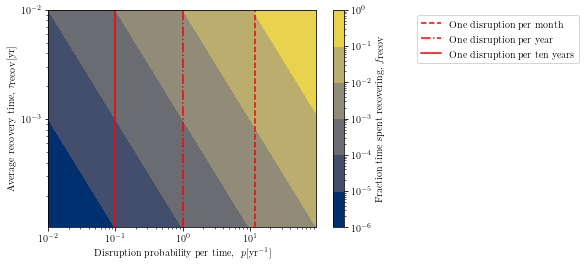

In [3]:
#Create contour plot and color bar
plt.contourf(p_mesh,tau_mesh,f_array,norm=colors.LogNorm(vmin=f_array.min(), vmax=1),cmap='cividis',vmax=1)
cbr= plt.colorbar(ticks=np.logspace(-6,0,7,endpoint=True))

if render_LaTeX:
    #Include lines showing one disruption per month, etc.
    plt.plot([(12),(12)],[tau_scan.min(),tau_scan.max()],color='red',linestyle='--',label=r'\textrm{One disruption per month}')
    plt.plot([(1),(1)],[tau_scan.min(),tau_scan.max()],color='red',linestyle='-.',label=r'\textrm{One disruption per year}')
    plt.plot([1/10,1/10],[tau_scan.min(),tau_scan.max()],color='red',linestyle='-',label=r'\textrm{One disruption per ten years}')
    plt.legend(bbox_to_anchor=(2, 1.0))

    #Add labels
    cbr.set_label(r'\textrm{Fraction time spent recovering, }$f_{\textrm{recov}}$')
    plt.ylabel(r'\textrm{Average recovery time, }$ \tau_{\textrm{recov}} [\textrm{yr}]$')
    plt.xlabel(r'\textrm{Disruption probability per time, } $p [\textrm{yr}^{-1}]$')
else:
    #Include lines showing one disruption per month, etc.
    plt.plot([(12),(12)],[tau_scan.min(),tau_scan.max()],color='red',linestyle='--',label='One disruption per month')
    plt.plot([(1),(1)],[tau_scan.min(),tau_scan.max()],color='red',linestyle='-.',label='One disruption per year')
    plt.plot([1/10,1/10],[tau_scan.min(),tau_scan.max()],color='red',linestyle='-',label='One disruption per ten years')
    plt.legend(bbox_to_anchor=(2, 1.0))

    #Add labels
    cbr.set_label('Fraction of lost operating time, f_recov')
    plt.ylabel('Average recovery time, τ_recov [yr]')
    plt.xlabel('Disruption probability per time, p [yr^-1]')

plt.yscale('log')
plt.xscale('log')

#Save plot and data
if save_data:
    plt.savefig('Plots/lost_time.png',dpi=200,bbox_inches='tight')
    np.save('Data/p_mesh.npy', p_mesh)
    np.save('Data/tau_mesh.npy', tau_mesh)
    np.save('Data/f_array.npy', f_array)

Requiring that the fraction of lost operating time is relatively small can be stated as
$$
    f_{\textrm{recov}}  < f_{\textrm{recov,max}} \ll 1,
$$
where $f_{\textrm{recov,max}}$ represents that maximum fraction of operating time that a utility can tolerate due to disruption recovery. For example, consider a TPP with a 4 month long maintenance time, such as what may be the case for DEMO. Let us assume we can tolerate up to $f_{\textrm{recov,max}} = 10$\% which is comparable to [3-6\% the Unplanned Capability Loss Factor of the world's nuclear power industry](https://pris.iaea.org/pris/worldstatistics/worldtrendinunplannedcapabilitylossfactor.aspx), and further assume 95\% of disruptions are correctly predicted and perfectly mitigated (meaning that maintenance is only required after an unmitigated disruption). In this scenario, the 4 months of unscheduled maintenance is only needed on average once per twenty disruptions, averaging out to a recovery time per disruption of $ \langle \tau_{\textrm{recov}} \rangle = 0.2$ months. Given 

In [4]:
#Function to compute maximum allowable disruption rate given f_lost_max
def get_p_recover(f_recover_max,tau):
    return f_recover_max/(tau*(1-f_recover_max))

p_example_recover = get_p_recover(0.10,0.2/12)
print(f'In this case, the maximum allowable disruption rate is {p_example_recover:.2f} [yr^-1]')

In this case, the maximum allowable disruption rate is 6.67 [yr^-1]


As we see, this case would have a disruption rate limit of $p < 6.67 \textrm{ yr}^{-1}$. For reference, this is about five orders of magnitude lower than disruption rate on JET, $p \approx 5 \cdot 10^{5} \textrm{ yr}^{-1}$. Below, we plot  $f_{\textrm{recov,max}}$ and $\langle \tau_{\textrm{recov}} \rangle$ for a range of values.

In [5]:
#### Parameter range to scan
f_recover_max_scan = np.logspace(-0.5,-1.99,50) #[-] Maximum fraction of operating time that a utility can tolerate due to disruption recovery

#Compute p
f_recover_max_mesh, tau_mesh, p_req_recover =  scan_2d(f_recover_max_scan, tau_scan, get_p_recover)

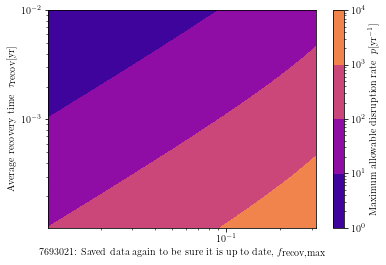

In [6]:
#Create contour plot and color bar
plt.contourf(f_recover_max_mesh,tau_mesh,p_req_recover,norm=colors.LogNorm(vmin=p_req_recover.min(), vmax=1e5),cmap='plasma')
cbr= plt.colorbar()

#Add labels
if render_LaTeX:
    cbr.set_label(r'\textrm{Maximum allowable disruption rate } $p [\textrm{yr}^{-1}]$')
    plt.ylabel(r'\textrm{Average recovery time } $\tau_{\textrm{recov}}  [\textrm{yr}] $')
    plt.xlabel(r'\textrm{7693021: Saved data again to be sure it is up to date, }$f_{\textrm{recov,max}}$')
else:
    cbr.set_label('Maximum allowable disruption rate [yr^-1]')
    plt.ylabel('Average recovery time τ_recov [yr]')
    plt.xlabel('Maximum tolerated fraction of operating time spent on recovery, f_recov,max')

plt.yscale('log')
plt.xscale('log')

#Save plot and data from plot
if save_data:
    plt.savefig('Plots/lost_time_disrupt_rate_limit.png',dpi=200)
    np.save('Data/f_recover_max_mesh.npy', f_recover_max_mesh)
    np.save('Data/tau_mesh.npy', tau_mesh)
    np.save('Data/p_req_recover.npy', p_req_recover)

## Reduced electricity production due to early shutdown

As discussed in the paper, disruptions could decrease electricity production by forcing an early plant closure. In this analysis, we will assume disruption rates are constant in time. Failure rates in most industrial applications typically follow one of four trends over time: flat, increasing, decreasing, or "bathtub-shaped" (i.e. relatively high failure rates early and late in life). For a TPP, machine aging could cause disruption rates to increase over time, but more operator experience could counteract this effect. Until we have empirical evidence from running a TPP, it is unclear what the trend will be in practice. For simplicity and tractability, we will neglect a time dependence on the disruption rates in this study.

The irreplaceable components on a TPP (for example, TF magnets) can be thought of as having an "acceptable damage budget." We can write the proportion of the damage budget that is consumed per unit time of operation as
$$ 
    \tau^{-1}_{\textrm{damage}} \equiv p  \langle d \rangle 
$$
wwhere $p$ is the probability of disruption per time and $\langle d \rangle \in [0,1]$ is the average damage per disruption as a proportion of the acceptable damage budget. For example, if every disruption is a class G event that renders the device inoperable, then $ \langle d \rangle  = 1$. We refer to $\tau_{\textrm{damage}}$ as the "characteristic damage time."

For a population of $N$ TPPs, the number that are lost due to damage per unit time $dt$ is approximately 
$$
    dN = -N \tau^{-1}_{\textrm{damage}} dt,
$$
from which we recognize that population decays exponentially. The probability that a particular TPP *does not* complete its target operational lifetime of $T$ is:
$$
    P_{\textrm{damage}}(T)  = 1 - \exp{\bigg (-\frac{T}{\tau_{\textrm{damage}}} \bigg )}.
$$
We plot $T=20$ years of operation considering only one disruption class with disruption rate $p$ with an average damage per disruption $\langle d \rangle$ for simplicity.

In [7]:
#Fuction to compute P_damage
def get_P_damage(T,p,d):
    return 1-np.exp(-T*(p*d))

#### Fixed parameter(s)
T=20 #[yr] planned operational lifetime

#### Parameter range to scan
p_damage_scan = np.logspace(-2,2,50) #[yr^-1] Disruption rate range to scan.

#Average damage per disruption as a proportion of damage budget
d_scan = np.logspace(-5,-1,40)

p_damage_scan_function = lambda p, d: get_P_damage(T,p,d)
p_damage_mesh, d_mesh, P_damage = scan_2d(p_damage_scan, d_scan, p_damage_scan_function)

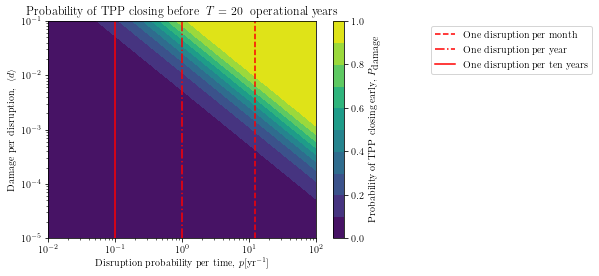

In [8]:
#Create contour plot and color bar
plt.contourf(p_damage_mesh,d_mesh,P_damage,levels=np.linspace(0,1,11),vmin=0,vmax=1)
cbr= plt.colorbar()

if render_LaTeX:
    #Include lines showing one disruption per month, etc.
    plt.plot([(12),(12)],[d_scan.min(),d_scan.max()],color='red',linestyle='--',label=r'\textrm{One disruption per month}')
    plt.plot([(1),(1)],[d_scan.min(),d_scan.max()],color='red',linestyle='-.',label=r'\textrm{One disruption per year}')
    plt.plot([1/10,1/10],[d_scan.min(),d_scan.max()],color='red',linestyle='-',label=r'\textrm{One disruption per ten years}')
    plt.legend(bbox_to_anchor=(2.05, 1.0))

    #Add labels
    plt.title(r'\textrm{Probability of TPP closing before } $T=20$ \textrm{ operational years}')
    cbr.set_label(r'\textrm{Probability of TPP closing early, }$P_{\textrm{damage}}$')
    plt.ylabel(r'\textrm{Damage per disruption, } $\langle d \rangle$')
    plt.xlabel(r'\textrm{Disruption probability per time,} $p [\textrm{yr}^{-1}]$')
else:
    #Include lines showing one disruption per month, etc.
    plt.plot([(12),(12)],[d_scan.min(),d_scan.max()],color='red',linestyle='--',label='One disruption per month')
    plt.plot([(1),(1)],[d_scan.min(),d_scan.max()],color='red',linestyle='-.',label='One disruption per year')
    plt.plot([1/10,1/10],[d_scan.min(),d_scan.max()],color='red',linestyle='-',label='One disruption per ten years')
    plt.legend(bbox_to_anchor=(2.05, 1.0))

    #Add labels
    plt.title('Probability of TPP closing before T=20 operational years')
    cbr.set_label('Probability of TPP closing early, P_damage')
    plt.ylabel('Damage per disruption, <d>')
    plt.xlabel('Disruption probability per time, p [yr^-1]')

plt.yscale('log')
plt.xscale('log')

#Save data from plot
if save_data:
    plt.savefig('Plots/damage.png',dpi=200,bbox_inches='tight')
    np.save('Data/d_mesh.npy', d_mesh)
    np.save('Data/p_damage_mesh.npy', p_damage_mesh)
    np.save('Data/P_damage.npy', P_damage)

We can compute a maximum allowable disruption rate $p$ given the utility's maximum allowable probability of an early plant closure due to damage $P_{\textrm{damage,max}} \ll 1$.

In [9]:
#Function to compute maximum allowable disruption rate
def get_p_damage(T,P_damage_max,d):
    return np.log(1/P_damage_max)/(T*d)

Consider a plant with a power producing lifetime of 20 years, a utility that tolerates $P_{\textrm{damage,max}}=0.1$, and $\langle d \rangle = 0.01$. 

In [10]:
p_example = get_p_damage(T,P_damage_max=0.1,d=0.01)
print(f'In this case, the maximum allowable disruption rate is {p_example:.2f} [yr^-1]')

In this case, the maximum allowable disruption rate is 11.51 [yr^-1]


We scan over a range of $P_{\textrm{damage,max}}$ and $\langle d \rangle$ below:

In [11]:
#### Parameter range to scan
P_damage_max_scan = np.logspace(-0.3,-2,50) #[-] Range of utility's maximum allowable probability of an early plant closure due to damage
d_scan = np.logspace(-5,-1,40) #[-] Average damage per disruption as a proportion of damage budget

#Compute maximum alloable disruption rate p_req
p_req_damage_scan_function = lambda P_damage_max, d: get_p_damage(T,P_damage_max, d)
P_damage_mesh, d_mesh, p_req_damage = scan_2d(P_damage_max_scan, d_scan, p_req_damage_scan_function)

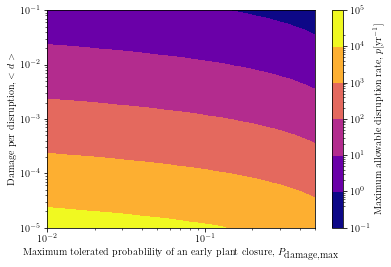

In [12]:
#Create contour plot and color bar
plt.contourf(P_damage_mesh,d_mesh,p_req_damage,norm=colors.LogNorm(vmin=p_req_damage.min(), vmax=p_req_damage.max()),cmap='plasma')
cbr= plt.colorbar()

if render_LaTeX:
    #Add labels
    cbr.set_label(r'\textrm{Maximum allowable disruption rate, }$p [\textrm{yr}^{-1}]$')
    plt.ylabel(r'\textrm{Damage per disruption, }$<d>$')
    plt.xlabel(r'\textrm{Maximum tolerated probablility of an early plant closure, }$P_{\textrm{damage,max}}$')
else:
    #Add labels
    cbr.set_label('Maximum allowable disruption rate, p [yr^-1]')
    plt.ylabel('Damage per disruption, <d>')
    plt.xlabel('Maximum tolerated probablility of an early plant closure, P_damage,max')

plt.yscale('log')
plt.xscale('log')

#Save data from plot
if save_data:
    plt.savefig('Plots/damage_disrupt_rate_limit.png',dpi=200)
    np.save('Data/P_damage_mesh.npy', P_damage_mesh)
    np.save('Data/d_mesh.npy', d_mesh)
    np.save('Data/p_req_damage.npy', p_req_damage)

# V.A Exploring the LCOE of an example Tokamak Power Plant (TPP)

We consider the case of a tokamak which experiences low expected time lost for disruption recovery ($ f_{\textrm{lost}} \ll 1$). We show in the paper that, in terms of the annual costs ($I_t,M_t,F_t$), and electrical energy production ($E_t$) of a hypothetical tokamak with no disruptions, then the LCOE of a TPP with disruptions can be written as
$$
  \textrm{LCOE}_{\textrm{disrupt}} \approx  \frac{\sum^{n}_{t=1} (\boldsymbol{k_{I,t}}I_t + \boldsymbol{k_{M,t}}M_t + F_t)(1+r)^{-t}}{ \sum^{n}_{t=1}  E_t\big(1+r\big)^{-t}  \boldsymbol{\Big(f_{\textrm{cons}}\Big)}  \boldsymbol{ \Big(1 - f_{\textrm{recov}}\Big)}   \boldsymbol{\Big(1-P_{\textrm{damage}}\big(T(t) \big)\Big)}} 
$$
with capital cost scaling factor $k_{I,t}$, O\&M cost scaling factor $k_{M,t}$, fraction of electrical power produced at the more conservative operating point $f_{\textrm{cons}}$, fraction of operating time lost due to disruption recovery actions $ f_{\textrm{recov}}$, total amount of the time by the end of year $t$ that the tokamak has been in operation $T(t)$, and probability that by year $t$ the plant will have been forced into an early shutdown due to disruptions $P_{\textrm{damage}}\big(T(t) \big)$. The new terms have been emphasized in bold. The only costs not affected by disruptions are the fuel costs, which are likely negligible relative to the capital and O\&M costs of a TPP.

We show how this methodology can be utilized in practice for a hypothetical TPP case. The baseline characteristics of the example without disruptions are shown below. We assume constant capital cost during the construction phase and constant O\&M and fuel costs in real terms. The LCOE as a function of various parameters is shown in the below plots

In [13]:
@dataclass
class DLCOEData:
    P_elect: float             #[MW] Electrical power
    I_t: float                 #[USD] Annual capital cost during construction. Assumed to be constant in real terms.
    M_t: float                 #[USD] Annual O&M cost. Assumed to be constant in real terms.
    F_t: float                 #[USD] Annual fuel cost. Assumed to be constant in real terms. 
    P_elect: float             #[MW] Electrical power
    duty_factor: float         #[-] Duty factor, i.e. fraction of calendar year that the device is creating power
    r: float                   #[-] Interest rate
    n_op: int                  #[yr] Number of years in operation
    n_construct: int           #[yr] Number of years under construction.
    k_I: float = 1.0           #[-] Capital cost multiplier
    k_M: float = 1.0           #[-] O&M cost multiplier
    f_cons: float = 1.0        #[-] Fraction of electrical power produced relative to non-disruptive baseline
    f_recover: float = 0.0     #[-] Fraction of operatonal time lost to disruption recovery
    tau_damage: float = np.inf #[yr] Characteristic damage time

    @property
    def E(self):
        """[MWh] Annual energy produced"""
        h_per_yr = 365 * 24 #[h/yr] Conversion factor of h to yr
        return self.P_elect*self.duty_factor*h_per_yr
    

#Create baseline case
baseline_data = DLCOEData(P_elect=500,     # Assume a 500 MWe plant.
                         I_t=4e8,          # Assume total captial cost is 2 billion dollars, spread out evenly over 5 years in real terms
                         M_t=5e7,          # Assume $5e7 annual O&M costs in real terms.
                         F_t=5e6,          # Assume $5e6 annual fuel costs in real terms.
                         duty_factor=0.8,  # Assume an 80% duty factor.
                         r=0.07,           # Assume a 7% interest rate.
                         n_op=20,          # Assume the plant will operate for 20 years.
                         n_construct=5)    # Assume the plant will be under construction for 5 years.


In [14]:
def get_LCOE_disrupt(data: DLCOEData):
    
    #We will sum up the numerator and denominator of the LCOE separately, and divide at the end
    n_tot=data.n_construct+data.n_op
    numerator=0
    denominator = 0
    
    #Over all years from the beginning of construction to retirement
    for t in range(n_tot):
        
        #If during construction
        if t<data.n_construct:
            numerator += data.k_I*data.I_t*(1+data.r)**(-t) #Add construction costs
        
        #Else during operation lifetime
        else:
            numerator += data.k_M*data.M_t*(1+data.r)**(-t)
            denominator += (1-data.f_recover)*data.f_cons*data.E*(1+data.r)**(-t)*(np.exp(-(t/data.tau_damage)*data.duty_factor))
    
    #Return LCOE
    return numerator/denominator

First, we compute the LCOE of the baseline case that does not experiment disruptions

In [15]:
LCOE_baseline=get_LCOE_disrupt(baseline_data)
print(f'The LCOE of the baseline, no disruption case is {LCOE_baseline:.2f} [$/MWh]')

The LCOE of the baseline, no disruption case is 76.24 [$/MWh]


### LCOE with respect to $k_I$,$k_M$ scan

All other values set to baseline no disruption case

In [16]:
#### Parameter range to scan
k_I_scan=np.linspace(1,3,40) #[-] Capital cost scaling factor
k_M_scan=np.linspace(1,3,40) #[-] O&M cost scaling factor

#Create scanner function
def scanner_k_I_k_M(k_I, k_M, TPP_data):
    data = copy.copy(TPP_data)
    data.k_I = k_I
    data.k_M = k_M
    return get_LCOE_disrupt(data)

#Compute LCOE
scanner_k_I_k_M_baseline = lambda k_I, k_M: scanner_k_I_k_M(k_I, k_M, baseline_data)
k_I_mesh, k_M_mesh, LCOE_k = scan_2d(k_I_scan, k_M_scan, scanner_k_I_k_M_baseline)

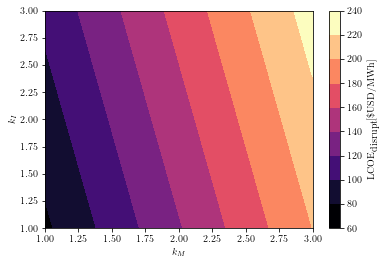

In [17]:
#Create contour plot and color bar
cs=plt.contourf(k_I_mesh,k_M_mesh,LCOE_k,cmap='magma',norm=colors.Normalize(vmin=LCOE_k.min(), vmax=LCOE_k.max()))
cbr= plt.colorbar()

if render_LaTeX:
    #Add labels
    cbr.set_label(r'$\textrm{LCOE}_\textrm{disrupt} [\textrm{\$USD/MWh}]$')
    plt.ylabel(r'$k_I$')
    plt.xlabel(r'$k_M$')   
else:
    #Add labels
    cbr.set_label('LCOE_disrupt [$USD/MWh]')
    plt.ylabel('k_I')
    plt.xlabel('k_M')

#Save data from plot
if save_data:
    plt.savefig('Plots/LCOE_k.png',dpi=200,bbox_inches='tight')
    np.save('Data/k_I_mesh.npy', k_I_mesh)
    np.save('Data/k_M_mesh.npy', k_M_mesh)
    np.save('Data/LCOE_k.npy', LCOE_k)

### LCOE with respect to $f_{\textrm{recov}}$,$f_{\textrm{cons}}$ scan
All other values set to baseline no disruption case

In [18]:
#### Parameter range to scan
f_cons_scan=np.logspace(-0.3,0,80) #[-] Fraction of target electrical power produced to keep sufficient margin to disruptive instabilities
f_recover_scan=np.logspace(-2,-0.3,80) #[-] Fraction of operating time lost to disruption recovery

#Create scanner function
def scanner_f_recover(f_cons, f_recover, TPP_data):
    data = copy.copy(TPP_data)
    data.f_cons = f_cons
    data.f_recover = f_recover
    return get_LCOE_disrupt(data)

#Compute LCOE
scanner_f_recover_baseline = lambda f_cons, f_recover: scanner_f_recover(f_cons, f_recover, baseline_data)
f_cons_mesh, f_recover_mesh, LCOE_f = scan_2d(f_cons_scan, f_recover_scan, scanner_f_recover_baseline)

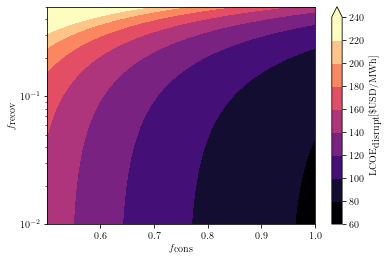

In [19]:
#Create contour plot and color bar
ax=plt.contourf(f_cons_mesh,f_recover_mesh,LCOE_f,cmap='magma',norm=colors.Normalize(vmin=LCOE_k.min(), vmax=LCOE_k.max()),levels=cs.levels,extend='max')
cbr= plt.colorbar()

if render_LaTeX:
    #Add labels
    cbr.set_label(r'$\textrm{LCOE}_\textrm{disrupt} [\textrm{\$USD/MWh}]$')
    plt.xlabel(r'$f_{\textrm{cons}}$')
    plt.ylabel(r'$f_{\textrm{recov}}$') 
else:  
    #Add labels
    cbr.set_label('LCOE_disrupt [$USD/MWh]')
    plt.xlabel('f_cons')
    plt.ylabel('f_recov')

plt.yscale('log')
plt.xscale('linear')

#Save data from plot
if save_data:
    plt.savefig('Plots/LCOE_f.png',dpi=200,bbox_inches='tight')
    np.save('Data/f_cons_mesh.npy', f_cons_scan)
    np.save('Data/f_recover_mesh.npy', f_recover_scan)
    np.save('Data/LCOE_f.npy', LCOE_f)

## LCOE($n_{\textrm{lifetime}}$,$\tau_{\textrm{damage}}$)
All other values set to baseline no disruption case

In [20]:
#### Parameter range to scan
tau_damage_scan=np.linspace(10,60,80) #[yr] Characteristic damage time
n_op_scan=np.arange(10,50,1) #[yr] Lifetime of plant (must be integers, hence arange)

#Create scanner function
def scanner_tau_nop(n_op, tau_damage,TPP_data):
    data = copy.copy(TPP_data)
    data.tau_damage = tau_damage
    data.n_op = n_op
    return get_LCOE_disrupt(data)

#Compute LCOE
scanner_tau_nop_baseline = lambda n_op, tau_damage: scanner_tau_nop(n_op, tau_damage, baseline_data)
n_op_mesh, tau_damage_mesh, LCOE_tau = scan_2d(n_op_scan, tau_damage_scan, scanner_tau_nop_baseline)

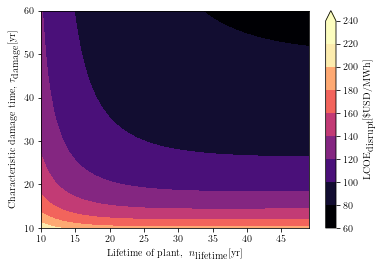

In [21]:
#Create contour plot and color bar
plt.contourf(n_op_mesh,tau_damage_mesh,LCOE_tau,cmap='magma',norm=colors.Normalize(vmin=LCOE_tau.min(), vmax=LCOE_tau.max()),levels=cs.levels,extend='max')
cbr= plt.colorbar()

if render_LaTeX:
    #Add a labels
    cbr.set_label(r'$\textrm{LCOE}_\textrm{disrupt} [\textrm{\$USD/MWh}]$')
    plt.ylabel(r'\textrm{Characteristic damage time, }$\tau_\textrm{damage} [\textrm{yr}]$')
    plt.xlabel(r'\textrm{Lifetime of plant, } $n_{\textrm{lifetime}} [\textrm{yr}]$')   
else:
    #Add a labels
    cbr.set_label('LCOE_disrupt [$USD/MWh]')
    plt.ylabel('Characteristic damage time, τ_damage [yr]')
    plt.xlabel('Lifetime of plant, n_lifetime [yr]')

if save_data:
    plt.savefig('Plots/LCOE_tau.png',dpi=200,bbox_inches='tight')
    np.save('Data/n_op_mesh.npy', n_op_mesh)
    np.save('Data/tau_damage_mesh.npy', tau_damage_mesh)
    np.save('Data/LCOE_tau.npy', LCOE_tau)

### Example of \$100 per MWh tokamak power plant with disruptions 

In each of the previous plots, we only scan two disruption related parameters at a time. To fully account for disruptions, one must consider the effect of all the disruption-related parameters together, which narrows the range to operate a profitable TPP.  

Consider the baseline TPP we have been using. If our goal was to create a TPP that can sell electricity of \$100 per MWH, one design that reaches the \$100/MWh target has $k_I = 1.5,\: k_M=1.25,\: f_{\textrm{recover}} = 0.03,\: f_{\textrm{margin}} = 0.99,\: \tau_{\textrm{damage}} = 200 \textrm{ yr},\textrm{ and } n_{\textrm{lifetime}}= 50 \textrm{ yr}$. These are fairly extreme requirements.

In [22]:
#Create new example
example_data = DLCOEData(P_elect=500,       # Assume a 500 MWe plant.
                         I_t=4e8,           # Assume total captial cost is 2 billion dollars, spread out evenly over 5 years in real terms.
                         M_t=5e7,           # Assume $5e7 annual O&M costs in real terms.
                         F_t=5e6,           # Assume $5e6 annual fuel costs in real terms.
                         duty_factor=0.8,   # Assume an 80% duty factor.
                         r=0.07,            # Assume a 7% interest rate.
                         n_op=50,           # Increae plant lifetime to 50 years compared to 20 in baseline case.
                         n_construct=5,     # Assume the plant will be under construction for 5 years.
                         k_I=1.5,           # Increase capital cost 50% compared to baseline case.
                         k_M=1.25,          # Increase O&M cost 25% compared to baseline case.
                         f_cons=0.99,       # Assume 99% of target electrical power produced to keep sufficient margin to disruptive instabilities.
                         f_recover=0.03,    # Assume 3% of operating time lost to disruption recovery.
                         tau_damage=200)    # Assume a characteristic damage time of 200 years.

LCOE_example=get_LCOE_disrupt(example_data)
print(f'The LCOE of the this case is {LCOE_example:.2f} [$/MWh]')

The LCOE of the this case is 99.52 [$/MWh]
